##Intro to Programming Project: Protein TAG Variant Screen

In [3]:
#@title Install dependencies
%%bash -s $use_amber $use_templates

set -e

USE_AMBER=$1
USE_TEMPLATES=$2

if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold"
  # high risk high gain
  pip install -q "jax[cuda11_cudnn805]>=0.3.8,<0.4" -f https://storage.googleapis.com/jax-releases/jax_releases.html
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  touch AMBER_READY
fi

In [19]:
#Loading all necessary modules/packages
#Input protein sequence(s)
from google.colab import files
import os.path
from os import path
import re
import hashlib
import random

#Run Prediction
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#User Iterface
import sys
!{sys.executable} -m pip install gradio
import gradio  as gr

#RMSD Calculations
!{sys.executable} -m pip install Bio
!{sys.executable} -m pip install rmsd
import Bio
from Bio import *
import numpy
import re
import glob
from pathlib import Path

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
K80_chk = !nvidia-smi | grep "Tesla K80" | wc -l
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

#Creates the directory path where the created PDB files are stored (if it doesnt exist already)
if(not (os.path.isdir("PDBs"))):
  os.mkdir("PDBs")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
#Functional approach to iterating over given dictionary of values

#Dictionary for TAG sequences
tag_sequences = {"6X His":"HHHHHH", "CBP":"KRRWKKNFIAVSAANRFKKISSSGAL",
                     "CBD + 3G": "GGGTNPGVSAWQVNTAYTAGQLVTYNGKTYKCLQPHTSLAGWEPSNVPALWQLQ",
                     "mNEONGreen + 5G": "GGGGGMVSKGEEDNMASLPATHELHIFGSINGVDFDMVGQGTGNPNDGYEELNLKSTKGDLQFSPWILVPHIGYGFHQYLPYPDGMSPFQAAMVDGSGYQVHRTMQFEDGASLTVNYRYTYEGSHIKGEAQVKGTGFPADGPVMTNSLTAADWCRSKKTYPNDKTIISTFKWSYTTGNGKRYRSTARTTYTFAKPMAANYLKNQPMYVFRKTELKHSKTELNFKEWQKAFTDVMGMDELYK"
                     }

#Hash function for producing keys for appending to jobname
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

#Takes a dictionary of values and builds an array of all the filepaths
def input_dict(variant_dict):
  #Clears PDBs files for analysis, so that new inputs can added
  PDB_dir = "/content/PDBs/"
  for PDB in os.listdir(PDB_dir):
    os.remove(os.path.join(PDB_dir,PDB))

  paths_dict = {}
  for name in variant_dict:
    # Initialization of the query_sequence
    # Removes whitespaces
    query_sequence = variant_dict[name]
    query_sequence = "".join(query_sequence.split())
    # Initialization of the jobname
    # Removes whitespaces and append hash key
    jobname = name
    basejobname = "".join(jobname.split())
    basejobname = re.sub(r'\W+', '', basejobname)
    jobname = add_hash(basejobname, query_sequence)
    while os.path.isfile(f"{jobname}.csv"):
      jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))

    with open(f"{jobname}.csv", "w") as text_file:
      text_file.write(f"id,sequence\n{jobname},{query_sequence}")

    #local variables needed to run prediction (most of these are adjustable, but for our purposes we are running them as default)
    #MS
    queries_path=f"{jobname}.csv"
    use_amber = False
    template_mode = "none"
    custom_template_path = None
    use_templates = False
    msa_mode = "MMseqs2 (UniRef+Environmental)"
    pair_mode = "unpaired+paired"
    a3m_file = f"{jobname}.a3m"
    model_type = "auto"
    num_recycles = 3
    save_to_google_drive = False
    dpi = 200

    input_array = [queries_path,use_amber,template_mode,custom_template_path,use_templates,msa_mode,pair_mode,a3m_file,model_type,num_recycles,save_to_google_drive,dpi]

    if use_amber and '/usr/local/lib/python3.7/site-packages/' not in sys.path:
      sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')

    jobname_path = run_prediction(jobname,input_array,"PDBs")
    paths_dict[name] = jobname_path

  #Deletes all files stored in the sample data (to clear room for subsequent runs)
  delete_dir = "/content/"
  for file in os.listdir(delete_dir):
    if(path.isfile(file)):
      os.remove(os.path.join(delete_dir,file))

  return paths_dict

def prediction_callback(unrelaxed_protein, length, prediction_result, input_features, type):
  fig = plot_protein(unrelaxed_protein, Ls=length, dpi=150)
  plt.show()
  plt.close()

#Runs a prediction and moves the resulting rank 1 pdb structure (model does not matter) into a desired directory
#Must provide the data array (contains all the parameters to run prediction) and directory path. 
#Returns the filepath of the PDB structure ofr the variant
def run_prediction(jobname,data_array,directory_name):
  #
  result_dir="."
  if 'logging_setup' not in globals():
      setup_logging(Path(".").joinpath("log.txt"))
      logging_setup = True
  
  queries_path=data_array[0]
  use_amber = data_array[1]
  template_mode = data_array[2]
  custom_template_path = data_array[3]
  use_templates = data_array[4]
  msa_mode = data_array[5]
  pair_mode = data_array[6]
  a3m_file = data_array[7]
  model_type = data_array[8]
  num_recycles = data_array[9]
  save_to_google_drive = data_array[10]
  dpi = data_array[11]
  
  queries, is_complex = get_queries(queries_path)
  model_type = set_model_type(is_complex, model_type)
  download_alphafold_params(model_type, Path("."))
  run(
      queries=queries,
      result_dir=result_dir,
      use_templates=use_templates,
      custom_template_path=custom_template_path,
      use_amber=use_amber,
      msa_mode=msa_mode,    
      model_type=model_type,
      num_models=5,
      num_recycles=num_recycles,
      model_order=[1, 2, 3, 4, 5],
      is_complex=is_complex,
      data_dir=Path("."),
      keep_existing_results=False,
      recompile_padding=1.0,
      rank_by="auto",
      pair_mode=pair_mode,
      stop_at_score=float(100),
      prediction_callback=prediction_callback,
      dpi=dpi
  )

  ex_end_path = ""

  for index in range(1,6):
    end_file = "_unrelaxed_rank_1_model_"+str(index)+".pdb"
    test_path = "/content/" + jobname + end_file
    if (os.path.exists(test_path)):
      ex_end_path = end_file

  old_path = "/content/" + jobname + ex_end_path
  new_path = "/content/"+ directory_name +"/" + jobname + ex_end_path
  os.replace(old_path,new_path)

  return new_path

2022-09-21 09:03:59,979 Found 5 citations for tools or databases
2022-09-21 09:04:04,614 Query 1/1: Protein0_bf020 (length 6)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


2022-09-21 09:04:05,200 Running model_1
2022-09-21 09:04:37,010 model_1 took 30.1s (3 recycles) with pLDDT 53.3 and ptmscore 0.0632


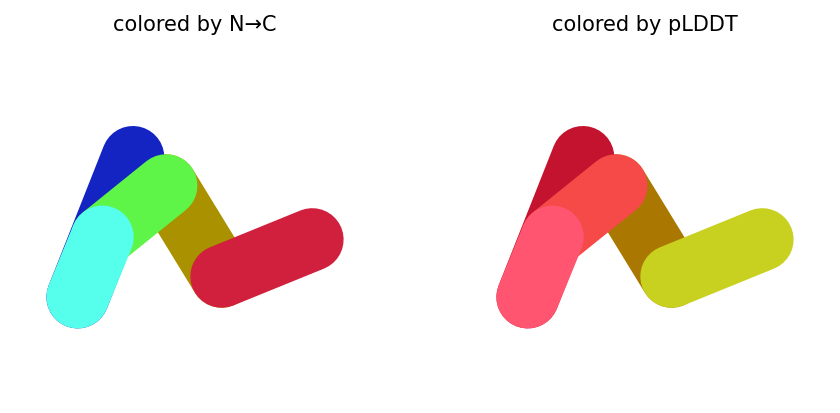

2022-09-21 09:04:37,432 Running model_2
2022-09-21 09:04:43,770 model_2 took 5.1s (3 recycles) with pLDDT 71.6 and ptmscore 0.063


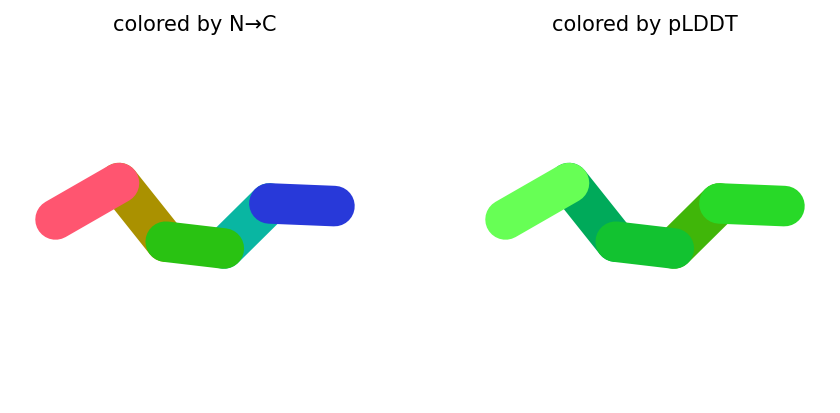

2022-09-21 09:04:44,198 Running model_3
2022-09-21 09:04:50,542 model_3 took 5.1s (3 recycles) with pLDDT 77 and ptmscore 0.066


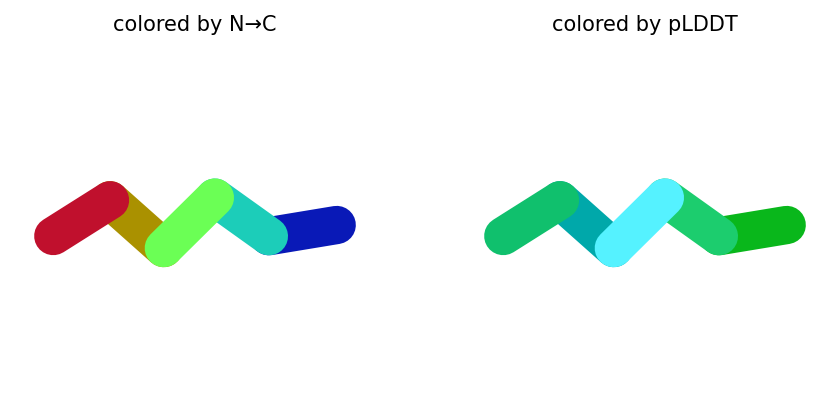

2022-09-21 09:04:51,191 Running model_4
2022-09-21 09:04:57,610 model_4 took 5.2s (3 recycles) with pLDDT 79.1 and ptmscore 0.0667


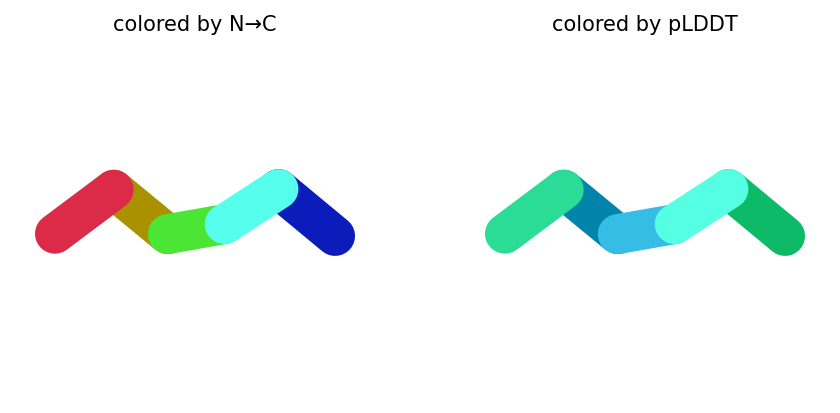

2022-09-21 09:04:58,003 Running model_5
2022-09-21 09:05:04,300 model_5 took 5.1s (3 recycles) with pLDDT 74 and ptmscore 0.0677


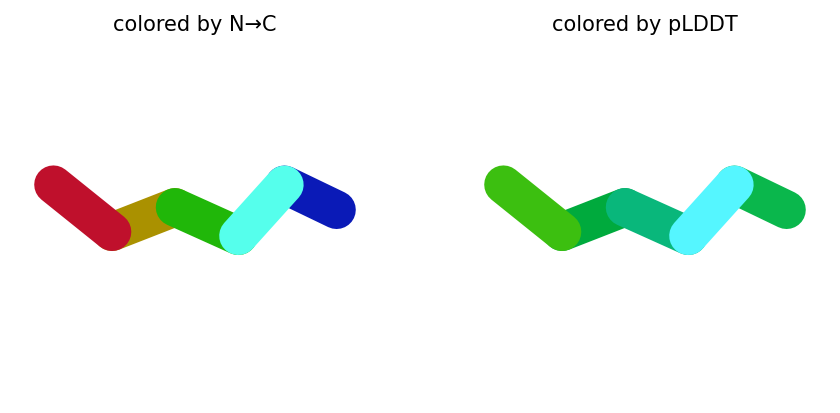

2022-09-21 09:05:04,685 reranking models by plddt
2022-09-21 09:05:05,886 Done


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


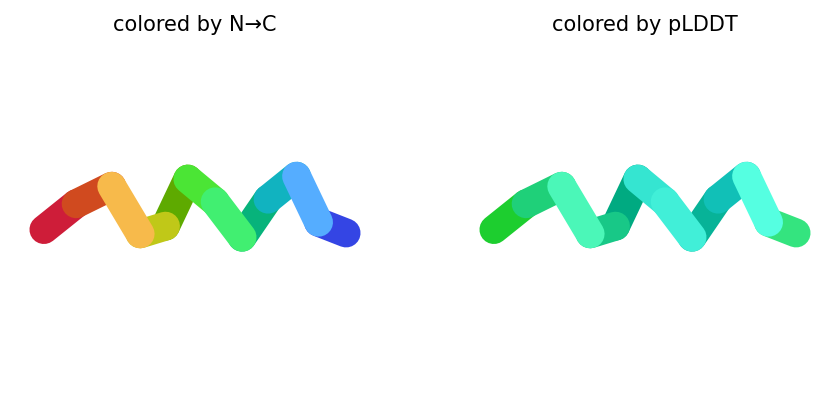

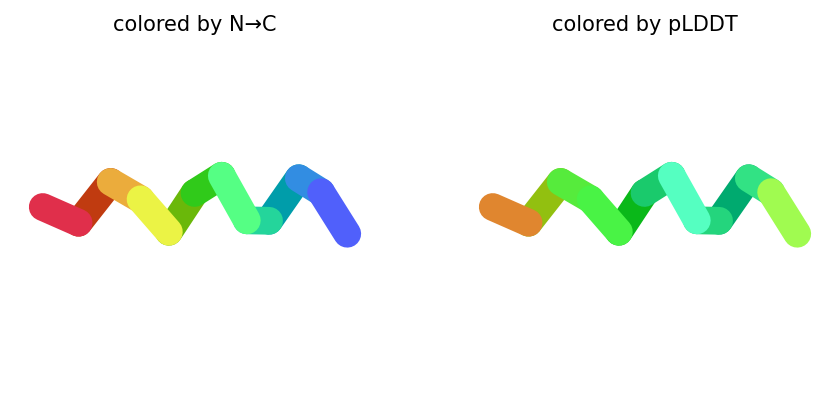

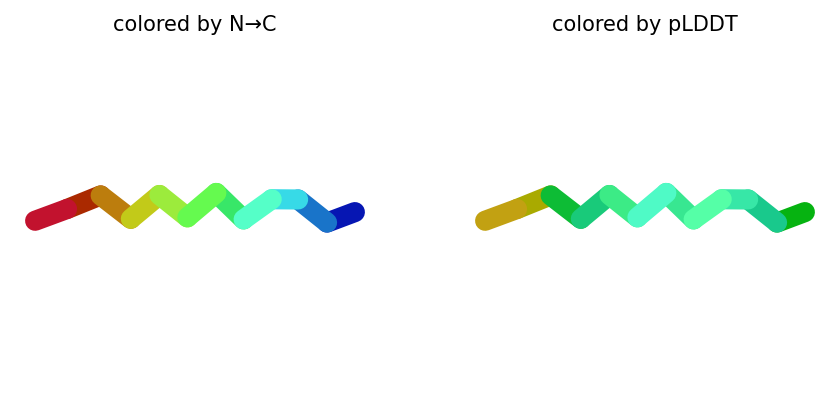

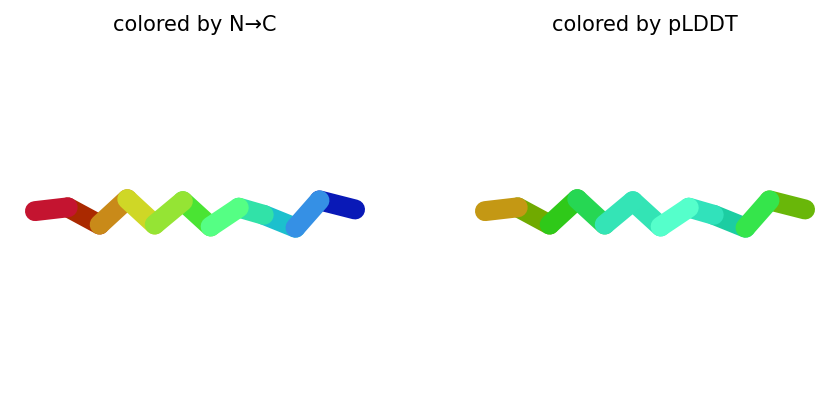

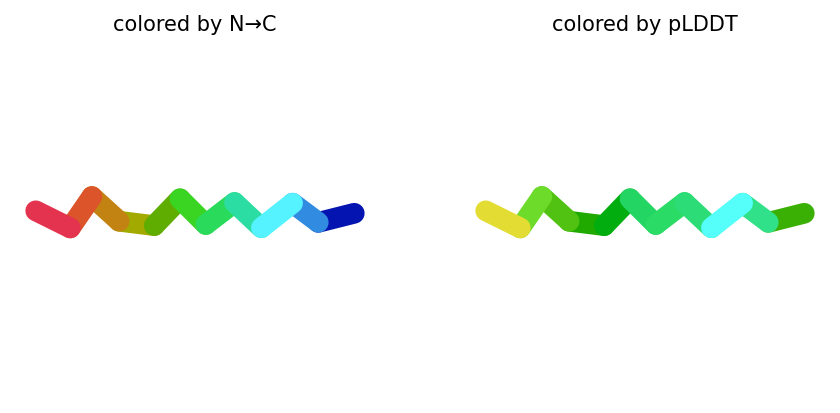

In [22]:
test_input = {'Protein0': 'EEMQRR', 'Protein0_6X His': 'EEMQRRHHHHHH'}

files = input_dict(test_input)

In [ ]:
print(files)

{'Protein0': '/content/PDBs/Protein0_6e630_unrelaxed_rank_1_model_4.pdb', 'Protein0_6X His': '/content/PDBs/Protein0_6XHis_02521_unrelaxed_rank_1_model_1.pdb'}


In [11]:
# Interface to determine number of proteins to compare where n is the number of proteins
# 1 <= n <= 10

files = {}

def count_protein(quantity):
    if (quantity == 1):
        return gr.Textbox.update(lines=1, visible=True,placeholder="Enter protein sequence.")
    else:
        return gr.Textbox.update(lines=quantity, visible=True,placeholder="Enter protein sequences separated by a semicolon\nEnter a new sequence per line.")

def parse_choices(protein_num,seq_string,tag_choices):
    variant_dict = process_variants(process_str(seq_string),tag_choices)
    files = input_dict(variant_dict)
    return files



def process_str(seq_string):
    seq_list = seq_string.split(";\n")
    return seq_list

def process_variants(seq_list,tag_choices):
    variant_list = {}
    for seq_index in range (0,len(seq_list)):
        ori_seq = "Protein" + str(seq_index)
        variant_list[ori_seq] = seq_list[seq_index]
        for tag in tag_choices:
            variant_name = ori_seq + "_" + tag
            variant_seq = seq_list[seq_index] + tag_sequences[tag]
            variant_list[variant_name] = variant_seq
    return variant_list
        

with gr.Blocks() as demo:
    gr.Markdown(
    """
    # Protein TAG Analyzer
    Configure below:
    """)
    slider = gr.Slider(1,10,1,step=1,label="Number of Protein(s)")
    text = gr.Textbox(lines=1, interactive=True,placeholder="Enter protein sequence.",label="Protein Sequence(s)")
    checkgroup = gr.CheckboxGroup(["6X His","CBP","CBD + 3G","mNEONGreen + 5G"],label="Select TAGs")
    generate = gr.Button()
    with gr.Row():
            with gr.Column(scale=1):
                text1 = gr.Textbox()
    
    slider.change(fn=count_protein,inputs=slider,outputs=text)
    generate.click(fn=parse_choices,inputs=[slider,text,checkgroup],outputs=text1)

demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://15292.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7fdc3495f410>,
 'http://127.0.0.1:7864/',
 'https://15292.gradio.app')